## HW02 - Linear and Ridge Regressions; K-Fold Cross Validation

### Name: Maida Raza

### Assignment description: 

In this assignment, I implemented and evaluated various polynomial regression models by analyzing prediction accuracy and error using both full-data fitting and 5-fold cross-validation. I then used ridge regression to reduce overfitting in more complex polynomial models. My goal with this task was to understand the relationship between model complexity, generalization, and regularization by systematically comparing performance across various polynomial degrees and regularization strengths.

In [2]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install seaborn
plt.style.use('seaborn-v0_8')
#plt.style.use('seaborn') # pretty matplotlib plots


### Plotting function

This function takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [3]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):

    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

# Q1 - Linear Regression Model Building and Analysis:

You have been given a data set (data.csv) consisting of some synthetically generated (input, output) (x, y) pairs, each represented by a single floating point value. You will write code that explores this data, using a number of different linear regression models.

1. You fill first fit a sequence of models, starting from a simple (degree-1) linear regression, and then continuing for data that is augmented using an increasing sequence of higher-degree polynomials.
    
    1.1. Fill in the test_polynomials function. This function should take in a list of positive integer values, corresponding to different degrees for polynomial models (so if the degree is 1, we get a purely linear model, if it is 2, we first transform the data so it is degree-2, and so on). Each model should be fit to the entire data-set, and then the model should be used to predict outputs for that data-set. The function will return two lists. One will consist of the predictions, i.e., it will be a list of length P, where P is the number of different polynomial degrees, and each element of the list consists of the N output values, where N is the size of the overall data-set). The other will consist of the P error values for the models, where error is calculated using the mean squared error metric (MSE). Once the function is completed, it should be called using the sequence of degrees d ∈ {1, 2, 3, 4, 5, 6, 10, 11, 12}. Once the function returns its two lists, the plot_predictions function (already written for you) will produce a plot containing each of the models’ predictions, along with their MSE values (found in the title area of each subplot).
    
    1.2. Discuss the plotted results. What do they show? What is the best model, based upon MSE? What models do particularly poorly? What does this tell you?


### Load the dataset

In [4]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [5]:
x = data.iloc[:, :-1].values 
y = data.iloc[:, 1].values
print(len(x))
print(y)

100
[ 2.84698753  2.95981066 13.04139392  3.97188913  2.45451984 16.48544905
  9.51285901 13.61977915 17.21988963  1.83125702 16.10263166  9.36246924
  1.98317929  7.81216976  1.32303926 12.701334   12.7115714   3.61815164
 14.7607757  10.73880708 16.40771023 14.90458224 16.82299736 12.89500833
  1.56392559 14.32355153 15.17157214 15.54152596  3.01934305 14.89018805
 16.66536217 11.53423541 11.22350391  2.02819945 16.56729842 16.38158402
 14.8628673  15.36796315 17.76751821  4.7222162  13.89746703 15.99779624
 -0.16138524  4.26988179  9.92258277  8.08247686 17.0487566  14.9901578
 15.26005077 16.36197386  5.17499382 13.86923022  0.38690353  2.2037644
  9.55379488 16.96185406 13.21199936  2.75514957 15.63419338 10.22883347
  5.92862789  7.53786891  6.52940265 17.04942126 16.2715444  11.17553864
 16.96939573 16.20156279 15.32256473  9.75045551 15.12863738  8.78910412
  7.15039539 13.79079258  9.65565423  4.34921447  0.92181874 13.45901485
 12.51918123 16.02999121 16.98245636 17.38941747 

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [6]:
def test_polynomials(polynomials=list()):
    
    e = []
    p = []
    
    for degree in polynomials:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(x)
        
        model = LinearRegression()
        model.fit(X_poly, y)
        y_prediction = model.predict(X_poly)
        p.append(y_prediction)
        
        mse = mean_squared_error(y, y_prediction)
        e.append(mse)    
        
    global prediction_list, error_list
    prediction_list = [arr.tolist() for arr in p] # Converting the array into a list
    error_list = e
    
    print(len(prediction_list), len(error_list))
    print([len(r) for r in prediction_list])
    
    #return error_list, prediction_list
test_polynomials([1,2,3,4,5, 6, 10, 11, 12])



9 9
[100, 100, 100, 100, 100, 100, 100, 100, 100]


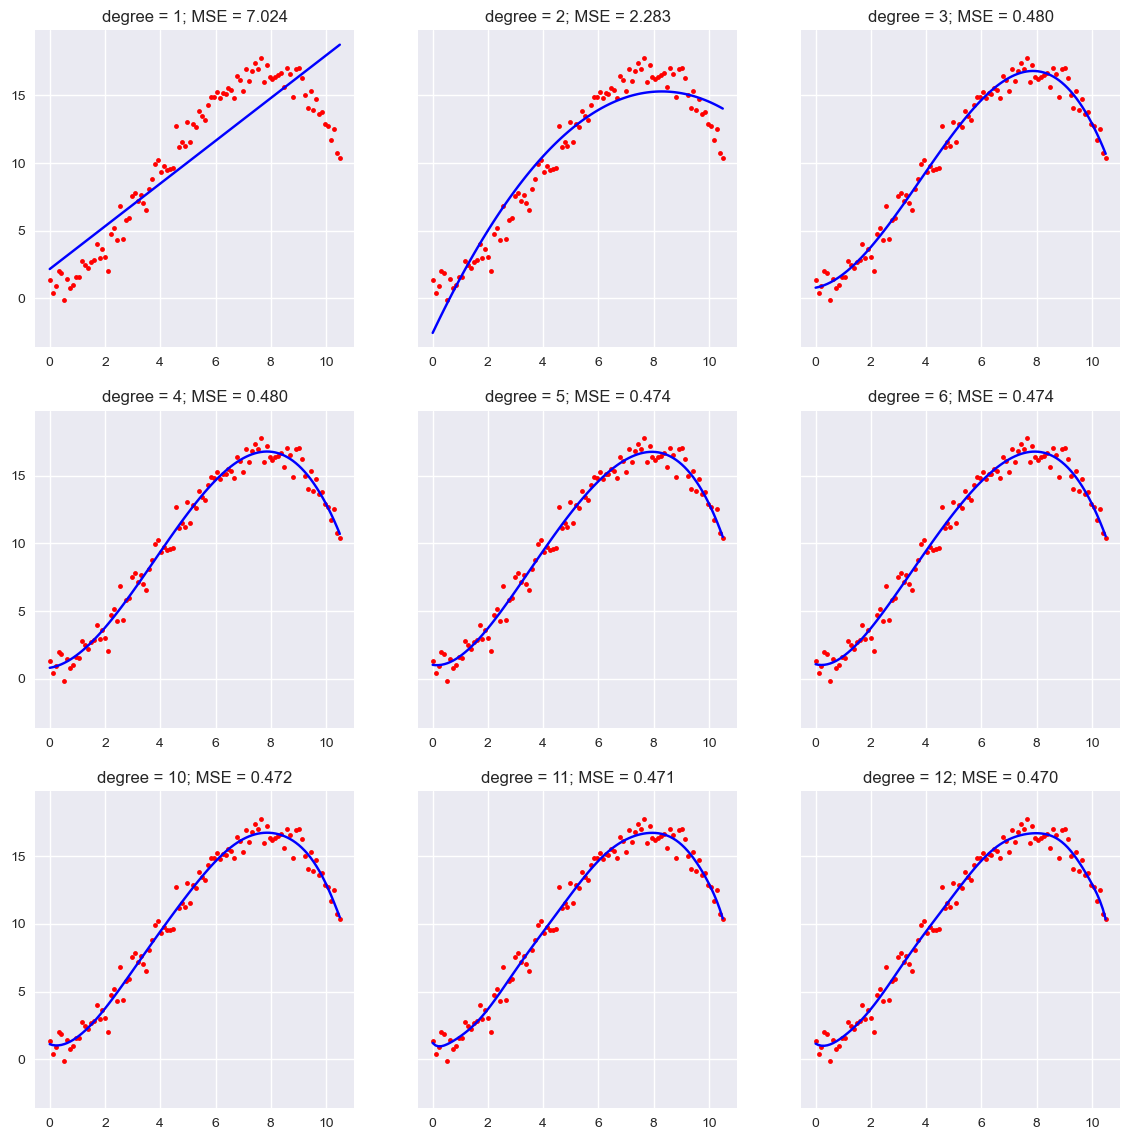

In [ ]:
# using plot_predictions to show the results

plot_predictions([1,2,3,4,5, 6, 10, 11, 12], prediction_list, error_list)


#### 1.2 Discuss the results seen in the plots above

**Discussion**:

In this example, we first transform the x-variable to fit the polynomial degree. We then fit a Linear Regression model on this transformed x-variable, using this transformed x-variable to generate prediction on y.

The plotted results demonstrate how well models with varying polynomial degrees fit the transformed x-variable. In this task, our goal is to reduce the Mean Squared Error (MSE). However, we want to be careful and not overfit the model. Since our goal is to reduce the MSE as much as possible, model with 12-degree polynomial is the best in terms of MSE. However, 12-degree polynomial model is over-fitting the data and has a low bias and high variance, meaning it will perform poorly on the testing data because it has understood the training data too well. 

On the other hand, the model with 1-degree polynomial does particularly poorly in terms of the MSE because it seems to be under-fitting the data, has a high bias and low variance - this model is not understanding the data well. 

I believe the best model, both for training and testing purposes is 3-degree polynomial because it is neither overfitting nor underfitting. From 5-Degree onwards, the model starts over-fitting the data, as demonstrated in the decreasing MSE.

# Q2 K-Fold Cross Validation:

2. You will now consider the same sequence of degrees as in the previous question. Instead of simply fitting the entire data-set, however, you will do 5-fold cross-validation, to allow an estimate of when the various models may be over-fitting to the data. We have supplied a make_folds function. This function takes a positive integer value, k, and divides the data-set (both x and y values) into k distinct sub-parts, where each part consists of the same number of elements (we will assume for the sake of this assignment that the data-set size divides evenly by the value k). The folds are returned in the form of two lists (for x and y), each of length k, where each element of a list consists of some consecutive sub-sequence of the original data, and each data-element is a member of exactly one fold (so that printing the contents of the k folds in order would give us back the exact same data-set). You will use this function in the rest of your code.
    
    2.1. For each of the polynomial degrees previously considered, perform 5-fold cross-validation on the data. That is, for each degree, your code should build 5 separate models, training each time on a different 4/5 of the data and testing on the remaining 1/5. You should use the make_folds function that we provided to split the data into the 5 parts—it is then up to you to re-combine parts as needed in each iteration of the cross-validation. You should keep track of the average training and testing error (MSE) seen over the 5 models, for each degree. You will then plot these results. This should consist of a single plot with:
    
    * The distinct polynomial degrees along the x-axis, and average MSE along the y-axis.
    * Average error plotted as two separate lines, one for training data and one for testing data; the lines should be distinguishable, by color or other features.
    * Proper labels on all axes, an explanatory title, and a legend making clear which line is which.
    
    Also: Following the plot, there should be tabular text print-out of the data as well; this can be in any clear format.

    2.2. Discuss the plotted results. What do they show? Where do we see the best results? Where is their underfitting, and why do you say that? Where is there overfitting, and why do you say that?

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [ ]:
x_folds = []
y_folds = []

def make_folds(x_data, y_data, num_folds=5):
    
    fold_length = (int)(len(x_data)/num_folds)
    start = 0
    
    for i in range(num_folds):
        end = start + fold_length
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + fold_length
        
    return x_folds, y_folds 




In [14]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
k = 5
x_folds, y_folds = make_folds(x, y, k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


/var/folders/y_/0vg5mwbj3qv394qthfv5h84c0000gn/T/ipykernel_5286/2054759647.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"


#### 2.1 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

Test MSE: [7.44115651272561, 2.6256081547920025, 0.5580828437253509, 0.5746231833029029, 0.5745796271735306, 0.5866062520239064, 0.6247477004352294, 0.6549482512501509, 0.6389208088537285]
Train MSE: [6.977640618384498, 2.245920078402712, 0.4716205597489326, 0.4699092227255776, 0.4636631806054682, 0.46206862640077795, 0.4571990531667695, 0.4532938417436956, 0.45327043793472993]


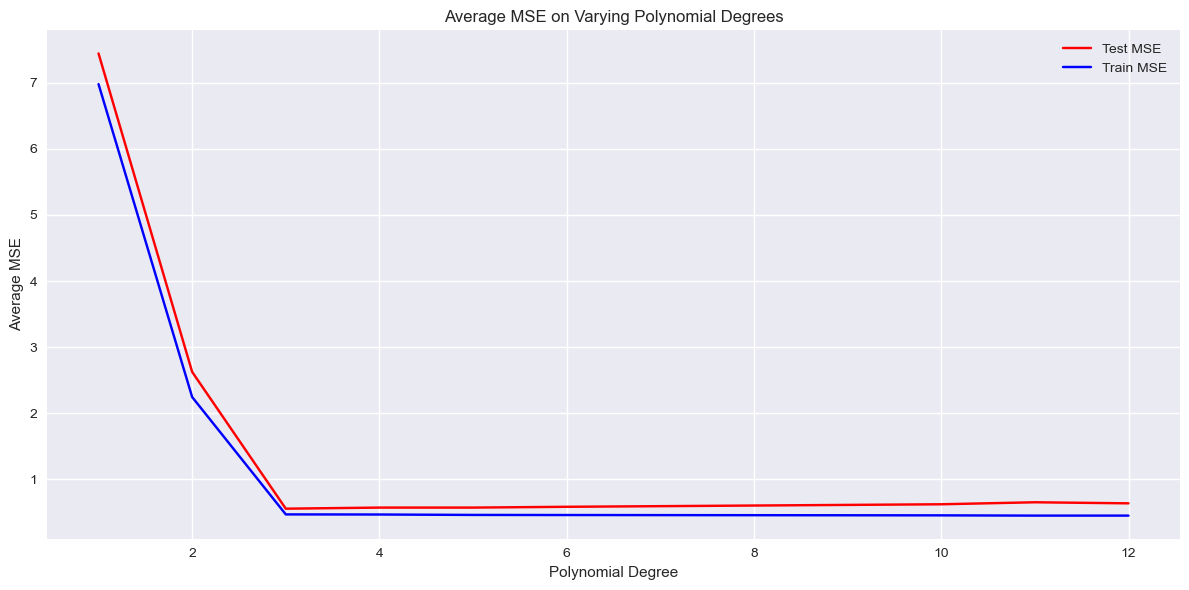


 5-Fold Cross Validation on Varying Polynomial Degrees: 

╒════╤═════════════════════╤═════════════════════╤════════════════════╕
│    │   Polynomial Degree │   Average Train MSE │   Average Test MSE │
╞════╪═════════════════════╪═════════════════════╪════════════════════╡
│  0 │                   1 │            6.97764  │           7.44116  │
├────┼─────────────────────┼─────────────────────┼────────────────────┤
│  1 │                   2 │            2.24592  │           2.62561  │
├────┼─────────────────────┼─────────────────────┼────────────────────┤
│  2 │                   3 │            0.471621 │           0.558083 │
├────┼─────────────────────┼─────────────────────┼────────────────────┤
│  3 │                   4 │            0.469909 │           0.574623 │
├────┼─────────────────────┼─────────────────────┼────────────────────┤
│  4 │                   5 │            0.463663 │           0.57458  │
├────┼─────────────────────┼─────────────────────┼────────────────────┤
│  5 

In [15]:
# In this exercise, we divide the data into 5 folds, changing the test data for every iteration. We calculate the MSE for every fold and then average it out for every degree over 5 iterations

x_folds, y_folds = make_folds(x,y,k)

polynomial_degree = [1, 2, 3, 4, 5, 6, 10, 11, 12]

total_test_mse = []
total_train_mse = []
d = []

for degree in polynomial_degree:
    
    test_mse_intermediate = 0
    train_mse_intermediate = 0
    
    for i in range(5):
        x_test = x_folds[i]
        y_test = y_folds[i]
        
        x_train = np.concatenate([x_folds[j] for j in range(5) if j!= i])
        y_train = np.concatenate([y_folds[j] for j in range(5) if j!=i])
        
        poly = PolynomialFeatures(degree)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
        
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        y_test_predict = model.predict(x_test_poly)
        y_train_predict = model.predict(x_train_poly)
        
        mse_test = mean_squared_error(y_test, y_test_predict)
        mse_train = mean_squared_error(y_train, y_train_predict)
        
        test_mse_intermediate = mse_test + test_mse_intermediate
        train_mse_intermediate = mse_train + train_mse_intermediate
        
    total_test_mse.append(test_mse_intermediate/5)
    total_train_mse.append(train_mse_intermediate/5)
    d.append(degree)
    
print('Test MSE:', total_test_mse) # Printing it for personal viewing purposes
print('Train MSE:', total_train_mse) # Printing it for personal viewing purposes

# Creating the plot
plt.figure(figsize=(12,6))
plt.plot(d, total_test_mse, color = 'red', label = 'Test MSE')
plt.plot(d, total_train_mse, color ='blue', label = 'Train MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Average MSE')
plt.title('Average MSE on Varying Polynomial Degrees')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Creating the table
from tabulate import tabulate # importing tabulate which formats tabular data into nicely printed tables

df = pd.DataFrame({
    'Polynomial Degree': d,
    'Average Train MSE': total_train_mse,
    'Average Test MSE': total_test_mse
})
print("\n 5-Fold Cross Validation on Varying Polynomial Degrees: \n")
print(tabulate(df, headers = 'keys', tablefmt ='fancy_grid'))


#### 2.2 Discuss the results seen in the plots above

**Discussion:** 

The plotted results demonstrate the average MSE for both training and test data over varying polynomial degrees. Note that the training and test datasets are created using the 5-fold cross validation method and they are changing at every iteration (5 iterations for each degree and then we average out the MSE).

In the graph above, we see that both training and test MSE's are relatively higher for 1-degree and 2-degree polynomial models. The errors on both test and training dataset on these degrees are high, demonstrating that the model is too simple to fit the data well. The training and test MSE's on 1-degree and 2-degree polynomial are closer to each other, demonstrating a low variance and a high bias. Hence, the model is underfitting on 1-degree and 2-degree polynomials.

The MSE reduces drastically, for both test and train data, on the 3-degree polynomial model. Afterwards, the test MSE starts increasing with every progressive polynomial degree, while the test MSE decreases. Therefore, we can conclude that the model starts overfitting (adding more features than necessary) from 4-degree polynomial model onwards. 

We see the best results with the 3-degree polynomial models. 




# Regularized Ridge Regression:

3. You will now examine ways in which a basic linear/polynomial model, of a fixed degree, can be adjusted to help avoid overfitting. One way to do this is via ridge regression. In this technique, rather than seek only to minimize error on the data-set, the regression model seeks to balance minimal error with weights that are smaller in magnitude (positive or negative)—that is, weights that are closer to 0. By doing this, there is often less chance that the model over-fits to one particular feature that is more characteristic of its training data than is representative of the overall truth. Discussion of ridge regression can be found in James et al. (section 6.2.1, pp. 215–219) [link] The model sklearn.linear_model.Ridge implements ridge regression. You will use this model to examine a range of regularization strengths, comparing how they affect performance on the entire data-set.∗

    3.1. Using whichever polynomial degree you found to give the best performance on the data-set (after cross-validation, in the second part of this assignment), generate a series of Ridge models:
    
    * Each model should use a different regularization strength; this value, set using the model parameter alpha, measures the penalty applied to large weights (so that a higher value means that the model tries even harder to keep weights small). You will generate a series of 50 distinct weights (and so 50 different models), distributed logarithmically over the interval [0.01, 100], using the code snippet: np.logspace(-2, 2, base=10, num=50)
    * You will do 5-fold cross-validation for each strength-value, again keeping track of average training and test error. (Do this the same way as in the prior question, using the supplied function to generate the folds required.)
    * You will again produce a plot comparing these results. The plot should satisfy the guidelines of the one produced for the second part of the assignment, clearly showingthe error results for each of the training and testing data. Again, a tabular version of the data should also be printed out.
    * Note: Since we are using a logarithmic scale for the strength values, the graphical plot should also use such a scale, to be most readable. This can be achieved using: matplotlib.pyplot.xscale('log')
    
    3.2. Discuss the plotted results. Where is the effect of increasing regularization strength helpful in avoiding overfitting, does it appear,

### 3. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 3.1 Cross-validation for each regularization strength value

Generate a sequence of 50 ridge models, varying the regularization strength from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and the resulting average training/test errors are tracked.  Errors are then plotted (on a logarithmic scale) and printed in some legible tabular form.


In [ ]:
# In this exercise, we will perform Ridge regression over 50 different alphas. The Ridge regression basically says that as the strength of alphas increase, the weights and emphasis on certain features decrease, preventing overfitting.
# Using the model above, we have determined that we will need to add additional features to attain ideal MSE, therefore Ridge is the optimal solution here and not Lasso
# Methodology: select degree -> for every alpha, create 5 fold models -> keep track of mse (average it at the end of every model)

import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

x_folds, y_folds = make_folds(x, y, k)

alpha =  np.logspace(-2,2, base = 10, num = 50)
test_mse = [] 
train_mse = []
alpha_label = []

def test_polynomials(polynomials=list()):
    
    for degree in polynomials:
        poly = PolynomialFeatures(degree)

        for a in alpha:
            
            alpha_label.append(a)
            test_mse_int = 0
            train_mse_int = 0

            for i in range(5):
                x_test = x_folds[i]
                y_test = y_folds[i]
                
                x_train = np.concatenate([x_folds[j] for j in range(5) if j != i] )
                y_train = np.concatenate([y_folds[j] for j in range(5) if j != i])

                x_train_poly = poly.fit_transform(x_train)
                x_test_poly = poly.fit_transform(x_test)
                
                model = Ridge(alpha=a)
                model.fit(x_train_poly, y_train)
                
                y_predict = model.predict(x_test_poly)
                y_train_pred = model.predict(x_train_poly)
                
                mse_test = mean_squared_error(y_test, y_predict)
                mse_train = mean_squared_error(y_train, y_train_pred)
                
                test_mse_int = test_mse_int + mse_test
                train_mse_int = train_mse_int + mse_train
        
            test_mse.append(test_mse_int/5) #divide it by 5 because you have 5-folds!
            train_mse.append(train_mse_int/5)
            
    print(len(test_mse), len(train_mse)) # should be 50 because we have 50 different alpha values
    print(test_mse, train_mse)
    
    # creating the plot
    plt.figure(figsize=(10,5))
    plt.xscale('log')
    plt.plot(alpha_label, test_mse, label = 'Test MSE')
    plt.plot(alpha_label, train_mse, label = 'Train MSE')
    plt.legend()
    plt.xlabel('Regularization Strength')
    plt.ylabel('Average MSE')
    plt.title('Average MSE Across Varying Regularization Strengths \n \n 3-Degree Polynomial Model')
    plt.tight_layout()
    plt.show()
    
    # Creating a table 
    from tabulate import tabulate
    df = pd.DataFrame({
        'Regularization Strength': alpha_label,
        'Average Test MSE': test_mse,
        'Average Train MSE': train_mse
    })
    print("\n Ridge Regression: Average MSE on a 3-degree Polynomial Model\n ")
    print(tabulate(df, headers='keys', tablefmt ='fancygrid'))
            
        

50 50
[0.558035983135507, 0.558026314998737, 0.5580146577064571, 0.558000604524564, 0.5579836666970376, 0.5579632574253219, 0.5579386729556997, 0.5579090703614753, 0.5578734416025939, 0.557830583469739, 0.5577790630987746, 0.5577171788945418, 0.5576429169726944, 0.5575539036605082, 0.5574473552564703, 0.5573200272088081, 0.5571681662207364, 0.5569874706050604, 0.556773066548261, 0.5565195107854111, 0.5562208333781035, 0.5558706374383809, 0.5554622750050219, 0.5549891186548486, 0.554444945114094, 0.5538244380763578, 0.5531238007419388, 0.5523414434920423, 0.5514786803868815, 0.5505403356593261, 0.5495351386450008, 0.5484757865300417, 0.5473785916282373, 0.5462627081821354, 0.5451490428989281, 0.5440590680146221, 0.543013842550223, 0.5420335814317957, 0.5411380910032955, 0.5403483386061495, 0.5396893874004872, 0.5391949506889502, 0.5389139340749792, 0.5389195518322003, 0.5393219260315222, 0.5402854997090236, 0.5420531165118658, 0.5449792345948342, 0.549575432167406, 0.5565720664973418] [

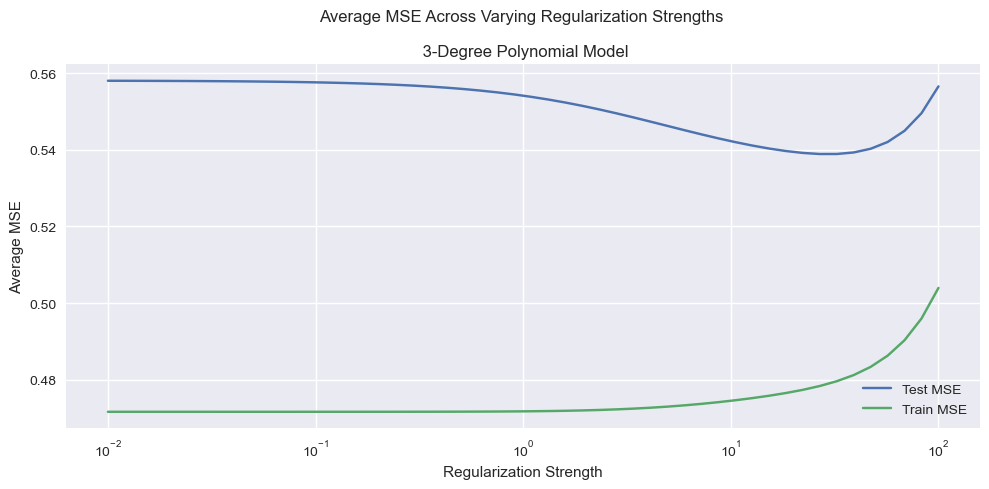


 Ridge Regression: Average MSE on a 3-degree Polynomial Model
 
      Regularization Strength    Average Test MSE    Average Train MSE
--  -------------------------  ------------------  -------------------
 0                  0.01                 0.558036             0.471621
 1                  0.0120679            0.558026             0.471621
 2                  0.0145635            0.558015             0.471621
 3                  0.0175751            0.558001             0.471621
 4                  0.0212095            0.557984             0.471621
 5                  0.0255955            0.557963             0.471621
 6                  0.0308884            0.557939             0.471621
 7                  0.0372759            0.557909             0.471621
 8                  0.0449843            0.557873             0.471621
 9                  0.0542868            0.557831             0.471621
10                  0.0655129            0.557779             0.471621
11          

In [13]:
test_polynomials([3])

#### Discussion of the results:

Regularization Strength (RS) in Ridge Regression controls the penalty applied to the model's coefficients. By increasing RS, the model shrinks the magnitude of its coefficients, reducing the influence of less important features and helping to control overfitting.

At low regularization strengths, the model tends to overfit the training data — it captures noise, resulting in low Train MSE but higher Test MSE, indicating poor generalization.

As RS increases, overfitting is reduced, and the model starts to generalize better. The optimal RS is around 56.9, where the Test MSE is minimized at 0.542053, and the Train MSE is 0.486267. This point represents the best balance between bias and variance.

Beyond RS ≈ 68.66, both Train and Test MSEs begin to rise, indicating underfitting — the model becomes too constrained to capture meaningful patterns in the data, and performance deteriorates.